In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import balanced_accuracy_score
import torch
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
# !pip install torchvision
import torchvision

import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# !pip install torchmetrics
import torchmetrics

In [2]:
df_images = pd.read_csv("image class.csv")[['image_name','class']]
class_names = df_images['class'].unique()
class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
df_images['label'] = df_images['class'].map(class_to_idx)
num_classes = len(class_names)
print(class_to_idx)
df_images

{'Cardboard': 0, 'Food Organics': 1, 'Glass': 2, 'Metal': 3, 'Miscellaneous Trash': 4, 'Paper': 5, 'Plastic': 6, 'Textile Trash': 7, 'Vegetation': 8}


,image_name,class,label
0,Cardboard_1.jpg,Cardboard,0
1,Cardboard_10.jpg,Cardboard,0
2,Cardboard_100.jpg,Cardboard,0
3,Cardboard_101.jpg,Cardboard,0
4,Cardboard_102.jpg,Cardboard,0
...,...,...,...
4747,Vegetation_95.jpg,Vegetation,8
4748,Vegetation_96.jpg,Vegetation,8
4749,Vegetation_97.jpg,Vegetation,8
4750,Vegetation_98.jpg,Vegetation,8


In [3]:
train_df, test_df = train_test_split(df_images, test_size=0.2, stratify=df_images['class'])

In [4]:
from torch.utils.data import Dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, image_folder, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.loc[idx, 'image_name']
        label = self.dataframe.loc[idx, 'label']

        img_path = os.path.join(self.image_folder, img_name)

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = CustomImageDataset(
    train_df,
    image_folder="all_images",
    transform=transform
)

test_dataset = CustomImageDataset(
    test_df,
    image_folder="all_images",
    transform=transform
)
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

for images, labels in test_loader:
    print(images.shape)
    print(labels.shape)
    break

    

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([32, 3, 224, 224])
torch.Size([32])


In [5]:
model = models.resnet18(weights="IMAGENET1K_V1")
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features,256),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 32),
    nn.LeakyReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, num_classes)
)

In [6]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=0.001
)

epoch_loss = {}

num_epochs = 10
print("Lets start")
for epoch in range(num_epochs):
    print(f'Epoch no. {epoch}')
    model.train() # train mode
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
     
    # Training Loss
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    epoch_loss[epoch] = running_loss/len(train_loader)
    # Testing Accuracy
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Balanced Classification Accuracy: {balanced_accuracy_score(all_labels, all_preds):.2f}")


Using device: cuda
Lets start
Epoch no. 0
Epoch [1/10], Loss: 1.7736
Test Balanced Classification Accuracy: 0.45
Epoch no. 1
Epoch [2/10], Loss: 1.2591
Test Balanced Classification Accuracy: 0.62
Epoch no. 2
Epoch [3/10], Loss: 1.0657
Test Balanced Classification Accuracy: 0.72
Epoch no. 3
Epoch [4/10], Loss: 0.9230
Test Balanced Classification Accuracy: 0.73
Epoch no. 4
Epoch [5/10], Loss: 0.8295
Test Balanced Classification Accuracy: 0.74
Epoch no. 5
Epoch [6/10], Loss: 0.7680
Test Balanced Classification Accuracy: 0.73
Epoch no. 6
Epoch [7/10], Loss: 0.7082
Test Balanced Classification Accuracy: 0.78
Epoch no. 7
Epoch [8/10], Loss: 0.6814
Test Balanced Classification Accuracy: 0.78
Epoch no. 8
Epoch [9/10], Loss: 0.6270
Test Balanced Classification Accuracy: 0.76
Epoch no. 9
Epoch [10/10], Loss: 0.5750
Test Balanced Classification Accuracy: 0.79


Test Accuracy: 77.50%
Balanced Accuracy:  0.7946051437990558
Precision: 0.780864966591386
Recall:  0.7749737118822292
                     precision    recall  f1-score   support

          Cardboard       0.71      0.82      0.76        92
      Food Organics       0.87      0.88      0.87        82
              Glass       0.64      0.95      0.77        84
              Metal       0.78      0.72      0.75       158
Miscellaneous Trash       0.74      0.51      0.60        99
              Paper       0.78      0.83      0.81       100
            Plastic       0.81      0.70      0.75       185
      Textile Trash       0.74      0.78      0.76        64
         Vegetation       0.92      0.98      0.95        87

           accuracy                           0.77       951
          macro avg       0.78      0.79      0.78       951
       weighted avg       0.78      0.77      0.77       951



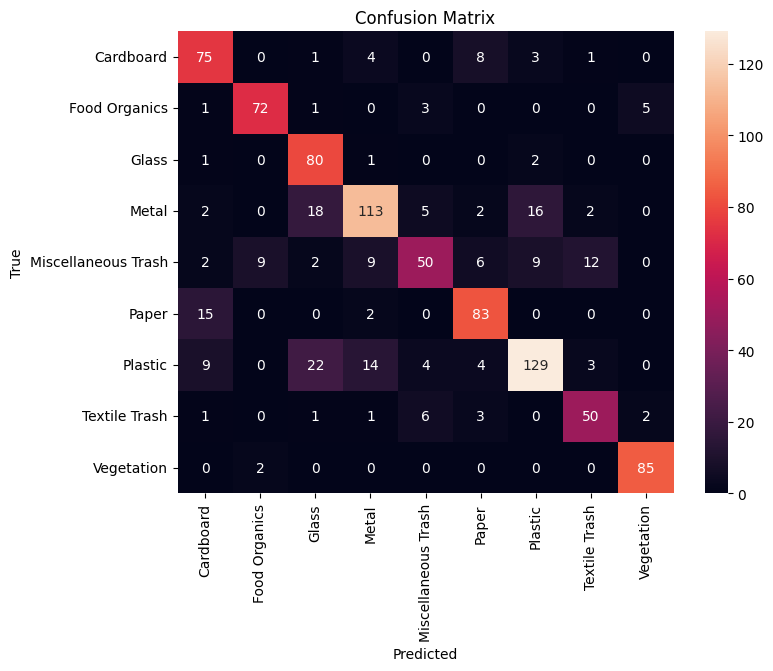

In [9]:
model.eval()  # evaluation mode

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")
print("Balanced Accuracy: ",balanced_accuracy_score(all_labels, all_preds))
print("Precision:",precision_score(all_labels, all_preds, average='weighted'))
print("Recall: ",recall_score(all_labels, all_preds,average='weighted'))

import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()